## Boilerplate

In [1]:
# Typical imports
import numpy as np
from scipy.spatial import Delaunay
from scipy.interpolate import RegularGridInterpolator
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from pylab import *
import cv2
import math
import sys
print(sys.version)

3.11.4 (main, Jul  5 2023, 08:40:20) [Clang 14.0.6 ]


# For updating my helper functions (sometimes you need to run this block twice)

In [2]:
# My own helper functions
import julians_little_helpers 
from julians_little_helpers import * 
# For reloading my helper functions when I make changes to them
import importlib
importlib.reload(julians_little_helpers)

<module 'julians_little_helpers' from '/Users/julian/Code/cs180/proj3/code/julians_little_helpers.py'>

# Part 1: Defining Correspondences
For this I chose to use a picture of myself (the photo I took for my student ID lol) and the given photo of George Clooney. 


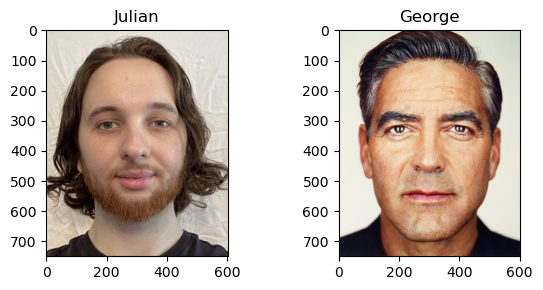

In [3]:
julian = read_im('../data/julian_portrait.jpg')
george = read_im('../data/george.jpg')
Display2Images(julian, george, 'Julian', 'George', 3)

#### Get the points I generated using this website: 
https://inst.eecs.berkeley.edu/~cs194-26/fa22/upload/files/proj3/cs194-26-aex/tool.html

(Thank you to whomever made this!)

In [37]:
# Import the correpsondence data
julian_pts, george_pts = GetPointsFromJSON('../data/julian_portrait_george.json')
julian_pts_xy = np.array(julian_pts)
george_pts_xy = np.array(george_pts)
# Reverse the ordering of the points from (x,y) to (y,x) 😡
julian_pts = np.column_stack((julian_pts_xy[:,1], julian_pts_xy[:,0]))
george_pts = np.column_stack((george_pts_xy[:,1], george_pts_xy[:,0]))

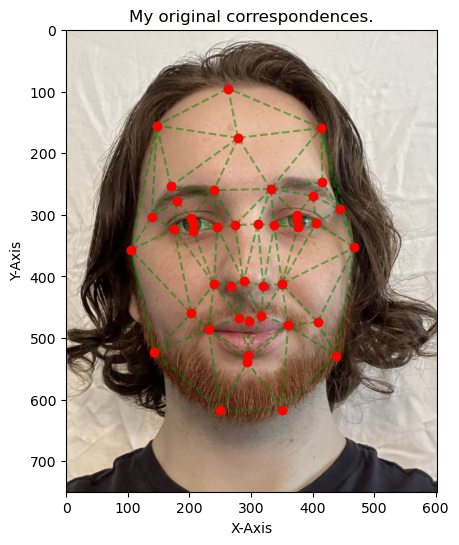

In [38]:
DisplayFaceTrisAndPts(julian, GetTriangulationObject(julian_pts_xy), julian_pts, 'My original correspondences.')

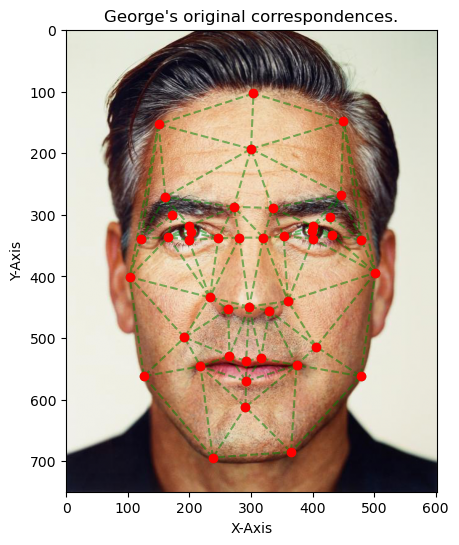

In [39]:
DisplayFaceTrisAndPts(george, GetTriangulationObject(george_pts_xy), george_pts, 'George\'s original correspondences.')

#### Get the "mid-way" shape of our faces.
i.e. get the mean of each set of points

In [7]:
midway_pts = GetMidwayFace(julian_pts, george_pts)

#### Calculate the Delaunay triangulation of the mid-way shape face.

In [8]:
midway_triangulation = GetTriangulationObject(midway_pts)

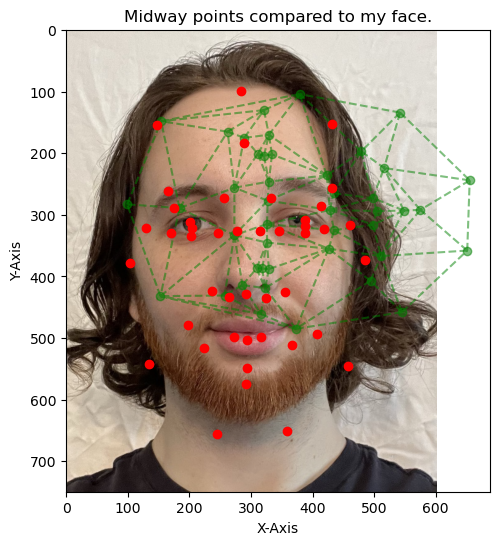

In [9]:
julian_tris = GetTriangulationObject(julian_pts)
DisplayFaceTrisAndPts(julian, midway_triangulation, midway_pts, 'Midway points compared to my face.')

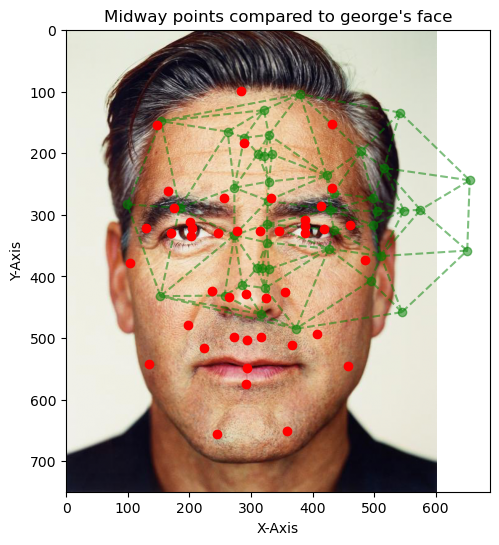

In [10]:
george_tris = GetTriangulationObject(george_pts)
DisplayFaceTrisAndPts(george, midway_triangulation, midway_pts, 'Midway points compared to george\'s face')

# Compute the affine transformation for every triangle in on our faces.

In [11]:

tri1 = np.array([[1, 2], 
                 [3, 4], 
                 [5, 6]])
tri1 = ConvertPointsToHomogenous(tri1)

tri2 = np.array([[7, 8], 
                 [9, 10], 
                 [11, 12]])
tri2 = ConvertPointsToHomogenous(tri2)

T = ComputeAffine(tri1, tri2)

print(tri1)
print(tri2)
print(T)
print(T @ tri1[0])
print(T @ tri1[1])
print(T @ tri1[2])

[[1. 2. 1.]
 [3. 4. 1.]
 [5. 6. 1.]]
[[ 7.  8.  1.]
 [ 9. 10.  1.]
 [11. 12.  1.]]
[[-1.33333333  2.33333333  3.66666667]
 [-1.66666667  2.66666667  4.33333333]
 [ 0.          0.          1.        ]]
[7. 8. 1.]
[ 9. 10.  1.]
[11. 12.  1.]


It works!

# Warp all pixels to the midway face shape by transforming them by the transformation matrix that transforms the triangle they are inside of to the midway face shape.

#### Hint: Use a mask using skimage polygon and polygon2mask (https://scikit-image.org/docs/dev/api/skimage.draw.html#skimage.draw.polygon). You could then use the mask to select only the triangle's pixels, transform that new image, and add these up for all triangles.

### Testing how to get an array of all the raw triangles.

In [12]:
from scipy.spatial import Delaunay
julian_delaunay = Delaunay(julian_pts)
#print(julian_delaunay.points)
#print(julian_delaunay.simplices)
"""
print("")
for simplex in julian_delaunay.simplices:
    print(f"[{julian_delaunay.points[simplex[0]]}, {julian_delaunay.points[simplex[1]]}, {julian_delaunay.points[simplex[2]]}]")
print("]")
"""

'\nprint("")\nfor simplex in julian_delaunay.simplices:\n    print(f"[{julian_delaunay.points[simplex[0]]}, {julian_delaunay.points[simplex[1]]}, {julian_delaunay.points[simplex[2]]}]")\nprint("]")\n'

### How to transform each triangle's pixels? Loop through the triangles, and for each:
1. First, get a binary mask of all of the pixels in the triangle
2. Take the array slice of the image with the binary mask
3. Transform the masked image by that triangle's affine transformation to the corresponding triangle in the target image.
#### Then add up all of these images!


### Let's test it on one triangle first.

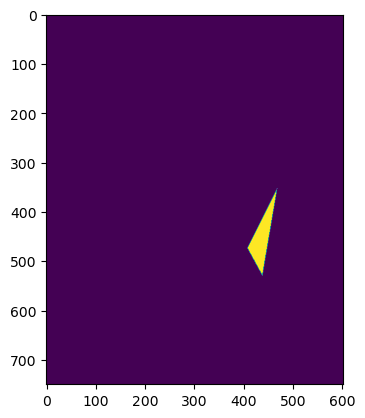

In [13]:
from skimage.draw import polygon2mask
from scipy.spatial import Delaunay
julian_delaunay = Delaunay(julian_pts)
# Single triangle test.
# Get the binary mask to select all pixels in the triangle.
tri_mask = polygon2mask(julian.shape[:2], julian_pts[julian_delaunay.simplices[0]]) # The first triangle in the triangulation
imshow(tri_mask)

### Let's try to make sure that the first triangle in George's triangulation is the same.

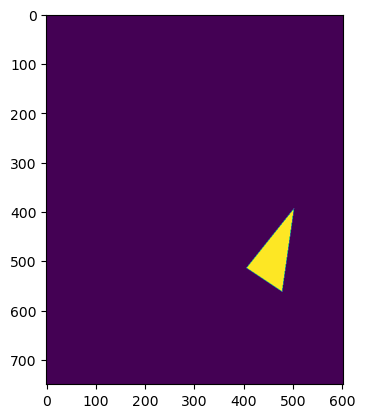

In [14]:
george_delaunay = Delaunay(george_pts)
tri_mask2 = polygon2mask(george.shape[:2], george_pts[george_delaunay.simplices[0]]) # The first triangle in the triangulation
imshow(tri_mask2)

### Ok. That's a bit of a problem. The simplices triangle matrix doesn't maintain the ordering of the points. 

Maybe there's a better solution, but here's what I'm thinking:
- the points in the julian_pts and george_pts arrays correspond based on index. 
- so, if I want to find the correpsonding triangle in both triangulations I should start with a point that I know the index of
- then, search for the triangles that have that point as an index (for both triangulations separately)
- the hard part is then matching 2 more points in any of those triangles to the other image's triangles...

### Ok. Actually its pretty easy because:
The simplices use the indices of the points in the julian_pts and george_pts arrays, which correspond.
So to find two corresponding triangles, we just need to get two triangles with the same simplices.

### Let's try this in a single instance.

In [15]:
# Get the first simplex in the triangulation
j_simplex1 = julian_delaunay.simplices[0]
print(j_simplex1)
# Let's find the corresponding triangle: search for the same simplex.
g_corr_simplex = None
matching_rows = [np.all(george_delaunay.simplices == j_simplex1, axis=1)]
print(matching_rows)

[36 42 23]
[array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])]


### I think I just realized that this is silly.
If every simplex exists in both triangles, then I can just iterate through the simplices from one of the triangulations and be fine...

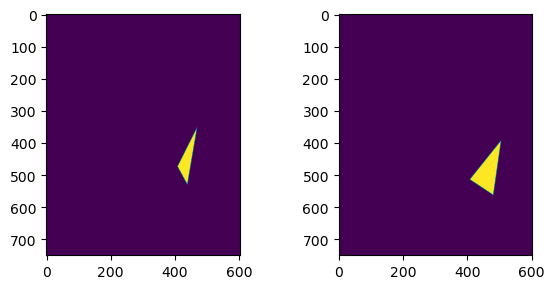

In [16]:
j_simplex1 = julian_delaunay.simplices[0]
j_mask1 = polygon2mask(julian.shape[:2], julian_pts[j_simplex1]) 
g_mask1 = polygon2mask(george.shape[:2], george_pts[j_simplex1])
Display2Images(j_mask1, g_mask1, '', '', 3)

# That's more like it!
#### Now, back to get the unmasked portion and transforming it!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[474. 408.   1.]
 [529. 438.   1.]
 [353. 468.   1.]]
[[514. 406.   1.]
 [562. 478.   1.]
 [394. 502.   1.]]
[[ 9.35064935e-01 -1.14285714e-01  1.17407792e+02]
 [ 2.07792208e-01  2.01904762e+00 -5.16264935e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


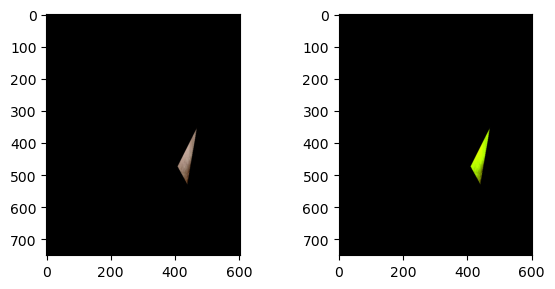

In [17]:
# Use the mask to perform binary array slicing.
j_tri = np.copy(julian)
j_tri [~j_mask1] = 0
# Compute transformation from one of my triangles to the corresponding triangle in george's face.
j_raw_tri = julian_pts[j_simplex1]
g_raw_tri = george_pts[j_simplex1]
# Convert triangle points to homogenous coordinates.
j_tri_pts = ConvertPointsToHomogenous(j_raw_tri)
print(j_tri_pts)
g_tri_pts = ConvertPointsToHomogenous(g_raw_tri)
print(g_tri_pts)
# Compute affine transfromation matrix from my triangle to george's triangle.
T = ComputeAffine(j_tri_pts, g_tri_pts)
print(T)
# Naively transform my triangle to george's triangle's shape.
j_tri_transformed = j_tri @ T
Display2Images(j_tri, j_tri_transformed, '', '', 3)

### Hm, clearly this was a naive implementation.
What I need to do is implement inverse warping. That means looping through all the pixels in the transformed shape, i.e. use the mask of george's triangle, and compute the coordinate in julian's image that correponds to the same point using the inverse of the transformation matrix. Because the resulting inverse coordinte is not necessarily an integer, I need to interpolate the value of the pixel at that coordinate. I can do this using bilinear interpolation.

In [18]:
# Testing the interpolation method.

x_dim = np.arange(0, julian.shape[1])
y_dim = np.arange(0, julian.shape[0])

r_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,0], method='linear', bounds_error=False, fill_value=None)
g_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,1], method='linear', bounds_error=False, fill_value=None)
b_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,2], method='linear', bounds_error=False, fill_value=None)

def interpolate_rgb(yx_coord):
    r = r_interpolator(yx_coord)
    g = g_interpolator(yx_coord)
    b = b_interpolator(yx_coord)
    return np.array((r, g, b)).reshape(1,3)

def interpolate_rgb_h(homogenous):
    return interpolate_rgb((homogenous[0], homogenous[1]))

rgb_value = interpolate_rgb([[50.0, 100.0]])
print(rgb_value)
print(julian[50, 100])
print(interpolate_rgb_h([50.0, 100.0, 1.0]))

[[0.88627451 0.85882353 0.81960784]]
[0.88627451 0.85882353 0.81960784]
[[0.88627451 0.85882353 0.81960784]]


In [19]:
# Get the inverse of the transformation matrix.
T_inv = np.linalg.inv(T)
print(f"Transformation matrix: \n{T}")
print(f"Inverse transformation matrix: \n{T_inv}")

# Initialize transformed image to zeros.
j_tri_t = np.zeros_like(julian)

# For every pixel coordinate position that is True in the mask of the transformed image (g_mask1)
for y in range(g_mask1.shape[0]):
    for x in range(g_mask1.shape[1]):
        if g_mask1[y][x]:
            # Get inverse coord
            coord = np.array([y, x, 1]).T
            inverse_coord = T_inv @ coord
            # Interpolate the value of the pixel at the inverse_coord.
            pixel_value = interpolate_rgb_h(inverse_coord)
            # set this coord to px value of inverse_coord
            j_tri_t[y][x] = pixel_value


Transformation matrix: 
[[ 9.35064935e-01 -1.14285714e-01  1.17407792e+02]
 [ 2.07792208e-01  2.01904762e+00 -5.16264935e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse transformation matrix: 
[[ 1.05615942e+00  5.97826087e-02 -9.31376812e+01]
 [-1.08695652e-01  4.89130435e-01  2.65282609e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


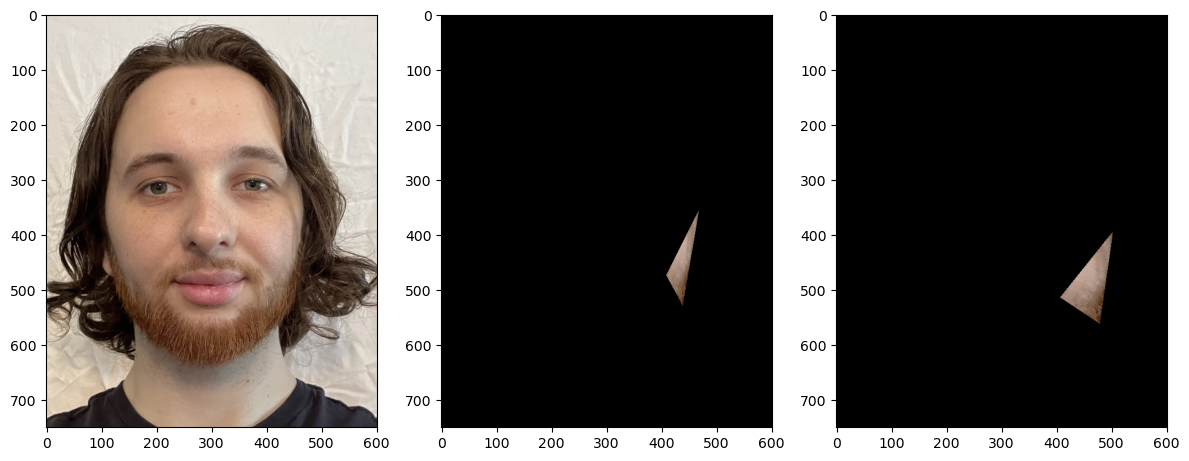

In [20]:
Display3Images(julian, j_tri, j_tri_t, '', '', '', 6)

# HOLD UP I THINK THAT ACTUALLY WORKED!

### Now, I just need to do this process for all of the triangles and add them up!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


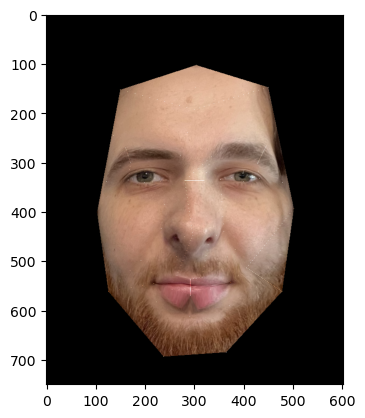

In [21]:
x_dim = np.arange(0, julian.shape[1])
y_dim = np.arange(0, julian.shape[0])

r_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,0], method='linear', bounds_error=False, fill_value=None)
g_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,1], method='linear', bounds_error=False, fill_value=None)
b_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,2], method='linear', bounds_error=False, fill_value=None)

def interpolate_rgb(yx_coord):
    r = r_interpolator(yx_coord)
    g = g_interpolator(yx_coord)
    b = b_interpolator(yx_coord)
    return np.array((r, g, b)).reshape(1,3)

def interpolate_rgb_h(homogenous):
    return interpolate_rgb((homogenous[0], homogenous[1]))

j_tris_transformed_ims = []
# For all triangles in the triangulation:
for i in range(len(julian_delaunay.simplices)):
    triangle_simplex = julian_delaunay.simplices[i]
    # Get the corresponding triangle shape from george's face.
    g_tri_mask_im = polygon2mask(george.shape[:2], george_pts[triangle_simplex])
    # Compute transformation from one of my triangles to the corresponding triangle in george's face.
    j_raw_tri = julian_pts[triangle_simplex]
    g_raw_tri = george_pts[triangle_simplex]
    # Convert triangle points to homogenous coordinates.
    j_tri_pts = ConvertPointsToHomogenous(j_raw_tri)
    g_tri_pts = ConvertPointsToHomogenous(g_raw_tri)
    # Compute affine transfromation matrix from my triangle to george's triangle.
    T = ComputeAffine(j_tri_pts, g_tri_pts)
    # Get the inverse of the transformation matrix.
    T_inv = np.linalg.inv(T)

    # Initialize transformed image to zeros.
    j_tri_t = np.zeros_like(julian)
    # For every pixel coordinate position that is True in the mask of the transformed image (g_mask1)
    for y in range(g_tri_mask_im.shape[0]):
        for x in range(g_tri_mask_im.shape[1]):
            if g_tri_mask_im[y][x]:
                # Get inverse coord
                coord = np.array([y, x, 1])
                inverse_coord = T_inv @ coord
                # Interpolate the value of the pixel at the inverse_coord.
                pixel_value = interpolate_rgb_h(inverse_coord)
                # set this coord to px value of inverse_coord
                j_tri_t[y][x] = pixel_value                 
    j_tris_transformed_ims.append(j_tri_t)

julian_transformed = np.zeros_like(julian)
for im in j_tris_transformed_ims:
    julian_transformed += im
# Add up the masks
# Divide result by the masks.
# Hint: Clamp zeros to ones.

imshow(julian_transformed) 

### Hm, something funky is going on...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


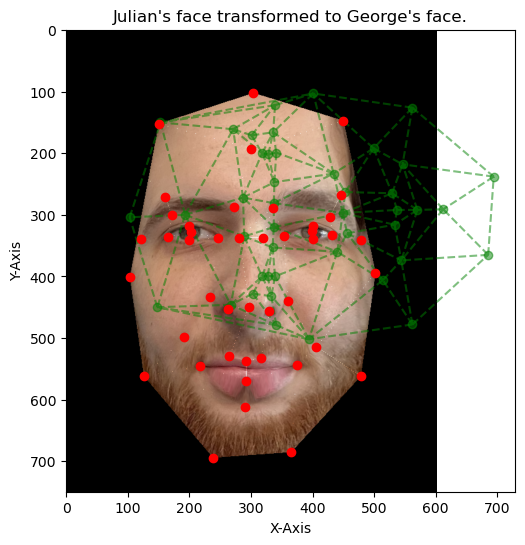

In [22]:
DisplayFaceTrisAndPts(julian_transformed, GetTriangulationObjectFromExistingDelaunay(george_pts, george_delaunay), george_pts, 'Julian\'s face transformed to George\'s face.')

### Dispaying some random triangles to see if they look right.

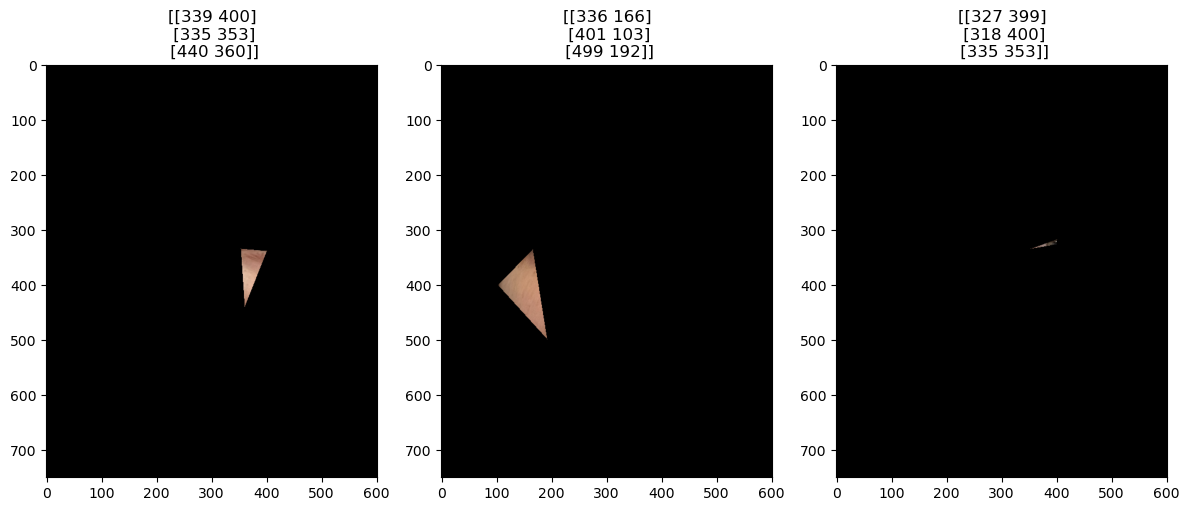

In [23]:
from random import randint
# Get 3 random images from j_tris_transformed_ims
i = [randint(0, len(j_tris_transformed_ims)) for i in range(3)]
Display3Images(j_tris_transformed_ims[i[0]], j_tris_transformed_ims[i[1]], j_tris_transformed_ims[i[2]], f'{george_pts[julian_delaunay.simplices[i[0]]]}', f'{george_pts[julian_delaunay.simplices[i[1]]]}', f'{george_pts[julian_delaunay.simplices[i[2]]]}', 6)


#### As you can see above, the coordinates of the triangles in the triangulations are not matching to the vertices of the triangles in the images. More experimentation is required. I think I should be gettign the points from george's points, since the triangles here should be the triangles from his triangulation.

## Failure case: index 13

Notice thaat the second point in george's triangle lies outside the image!
Although, this would also imply that some of the points in the correspondance array are outside the image as well...

[33  0  6]
original julian triangle:
[[412 240]
 [320 245]
 [327 206]]
george triangle:
[[434 233]
 [338 247]
 [341 199]]


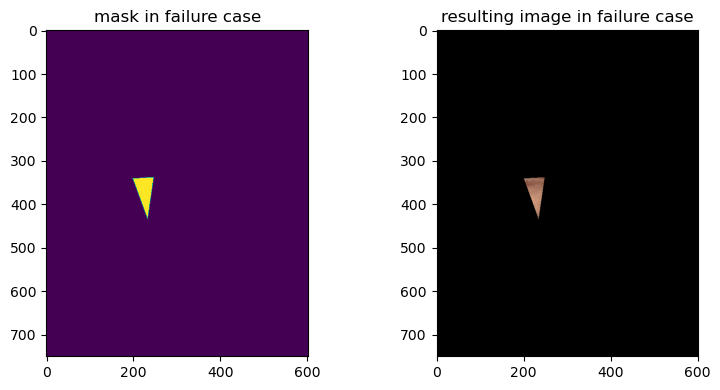

In [24]:
print(julian_delaunay.simplices[13])
print(f"original julian triangle:\n{julian_pts[julian_delaunay.simplices[13]]}")
print(f"george triangle:\n{george_pts[julian_delaunay.simplices[13]]}")
failure_mask = polygon2mask(george.shape[:2], george_pts[julian_delaunay.simplices[13]])
failure_case_im = j_tris_transformed_ims[13]
Display2Images(failure_mask, failure_case_im, 'mask in failure case', 'resulting image in failure case', 4)

## Another failure: index 9

[35  2 17]
[[412 350]
 [317 338]
 [415 320]]


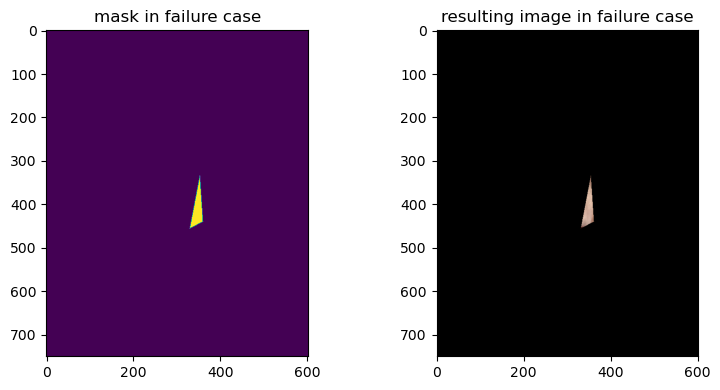

In [25]:
print(julian_delaunay.simplices[9])
print(julian_pts[julian_delaunay.simplices[9]])
failure_mask = polygon2mask(george.shape[:2], george_pts[julian_delaunay.simplices[9]])
failure_case_im = j_tris_transformed_ims[9]
Display2Images(failure_mask, failure_case_im, 'mask in failure case', 'resulting image in failure case', 4)

## Loop through george's and julian's correpsondance points, check if any are outside image bounds.

In [26]:
for point in julian_pts:
    if point[0] > julian.shape[0] or point[1] > julian.shape[1] or point[0] < 0 or point[1] < 0:
        print(f"invalid point in julian_pts: {point}")

for point in george_pts:
    if point[0] > julian.shape[0] or point[1] > julian.shape[1] or point[0] < 0 or point[1] < 0:
        print(f"invalid point in george_pts: {point}")

# I found the bug!😭 
### It was that the correspondance tool exports the coordinates in (x,y) format. I didn't notice this earlier because for some reason the matplotlib triangulation object I used to graph the points was also in (x,y) format. 
# 🤦🏻‍♂️

# Ok, now lets just Copy and paste the code and make sure to reverse the coordinates first.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


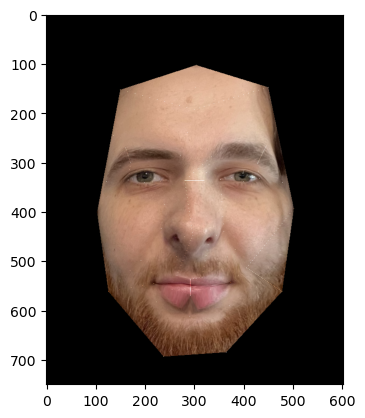

In [32]:
x_dim = np.arange(0, julian.shape[1])
y_dim = np.arange(0, julian.shape[0])

r_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,0], method='linear', bounds_error=False, fill_value=None)
g_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,1], method='linear', bounds_error=False, fill_value=None)
b_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,2], method='linear', bounds_error=False, fill_value=None)

def interpolate_rgb(yx_coord):
    r = r_interpolator(yx_coord)
    g = g_interpolator(yx_coord)
    b = b_interpolator(yx_coord)
    return np.array((r, g, b)).reshape(1,3)

def interpolate_rgb_h(homogenous):
    return interpolate_rgb((homogenous[0], homogenous[1]))

# Code from above, copy pasted:

j_tris_transformed_ims = []
masks = []
# For all triangles in the triangulation:
for i in range(len(julian_delaunay.simplices)):
    triangle_simplex = julian_delaunay.simplices[i]
    # Get the corresponding triangle shape from george's face.
    g_tri_mask_im = polygon2mask(george.shape[:2], george_pts[triangle_simplex])
    masks.append(g_tri_mask_im)
    # Compute transformation from one of my triangles to the corresponding triangle in george's face.
    j_raw_tri = julian_pts[triangle_simplex]
    g_raw_tri = george_pts[triangle_simplex]
    # Convert triangle points to homogenous coordinates.
    j_tri_pts = ConvertPointsToHomogenous(j_raw_tri)
    g_tri_pts = ConvertPointsToHomogenous(g_raw_tri)
    # Compute affine transfromation matrix from my triangle to george's triangle.
    T = ComputeAffine(j_tri_pts, g_tri_pts)
    # Get the inverse of the transformation matrix.
    T_inv = np.linalg.inv(T)

    # Initialize transformed image to zeros.
    j_tri_t = np.zeros_like(julian)
    # For every pixel coordinate position that is True in the mask of the transformed image (g_mask1)
    for y in range(g_tri_mask_im.shape[0]):
        for x in range(g_tri_mask_im.shape[1]):
            if g_tri_mask_im[y][x]:
                # Get inverse coord
                coord = np.array([y, x, 1])
                inverse_coord = T_inv @ coord
                # Interpolate the value of the pixel at the inverse_coord.
                pixel_value = interpolate_rgb_h(inverse_coord)
                # set this coord to px value of inverse_coord
                j_tri_t[y][x] = pixel_value                 
    j_tris_transformed_ims.append(j_tri_t)

julian_transformed = np.zeros_like(julian)
for im in j_tris_transformed_ims:
    julian_transformed += im
# Add up the masks
mask_weights = np.zeros_like(j_mask1)
for mask in masks:
    mask_weights += mask
mask_weights[mask_weights < 1] = 1
# Divide the result image by the mask weights (overlapping masks)
julian_transformed[:, :, 0] /= mask_weights
julian_transformed[:, :, 1] /= mask_weights
julian_transformed[:, :, 2] /= mask_weights
imshow(julian_transformed) 

## Ok, at least the mask is properly aligned now. But the points being sampled are totally off.

## I don't have time to do this currently. Going to accelerate the process by going to Jake's office hours later and seeing if he has any clever ideas on what sort of logic problems I'm having.

# IDEA: ADD UP THE masks and divide the end result by that, don't forget to clamp to 1 so that you don't divide by zero


# Compute the morph sequence by writing a function morph(...) 

#### which will have parameters for weighting the interpolation (either more of face 1 or more of face 2). Basically, run the warping procedure we've established up until now with weighted amount of warping between the images and weighted amounts of cross-dissolving. When those variables reach 1 (starting from 0) the morph sequence will be complete.
# TODO: implement this 

# Turn a sequence of computed interpolated images into a GIF which shows the face morph.

In [28]:
# TODO: implement this